In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import climtas
import xarray
import glob
import dask

In [3]:
import os
import dask.distributed

# Edit as desired
threads_per_worker = 1

try:
    c # Already running
except NameError:
    c = dask.distributed.Client(
        n_workers=int(os.environ['PBS_NCPUS'])//threads_per_worker,
        threads_per_worker=threads_per_worker,
        memory_limit=f'{4*threads_per_worker}gb',
        local_directory=os.path.join(os.environ['PBS_JOBFS'],
                                     'dask-worker-space')
    )
c

Client Scheduler: tcp://127.0.0.1:42351 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.00 GB


In [4]:
ds = xarray.open_mfdataset(sorted(glob.glob('/g/data/w35/dh4185/data/AWAP/awra_sm_pct/sm_pct_*.nc')), 
                           combine='nested', 
                           concat_dim='time',
                           chunks={'latitude':10, 'longitude': 100})
ds

<xarray.Dataset>
Dimensions:    (latitude: 681, longitude: 841, time: 39637)
Coordinates:
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 ... -43.9 -43.95 -44.0
  * longitude  (longitude) float64 112.0 112.0 112.1 112.2 ... 153.9 153.9 154.0
  * time       (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2019-07-09
Data variables:
    sm_pct     (time, latitude, longitude) float32 dask.array<chunksize=(365, 10, 100), meta=np.ndarray>
Attributes:
    var_name:       sm_pct
    Conventions:    CF-1.6, ACDD-1.3
    institution:    Bureau of Meteorology
    summary:        Data produced by Bureau of Meteorology Australian Water R...
    url:            http://www.bom.gov.au/water/landscape
    title:          Australian Landscape Water Balance AWRA-L Model Version 6
    email:          awrams@bom.gov.au
    date_created:   2018-11-02T12:18:48
    source:         AWRA-L-v6)
    Description:    This data is provided by the Bureau of Meteorology and ca...
    date_modified:  2018-11-02T12:18:48

In [5]:
climtas.helpers.dask_report(ds.sm_pct)

Chunk Count: 67689
Chunk Size: 1.46 MB
Graph Size: 135487


In [6]:
r = climtas.rank.rank_by_dayofyear(ds.sm_pct)
r

<xarray.DataArray 'sm_pct' (time: 39637, latitude: 681, longitude: 841)>
dask.array<chunk_apply_by_dayofyear-1629d48891dcc3fba6fa8023d2d35417-<this, shape=(39637, 681, 841), dtype=float32, chunksize=(39637, 10, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 ... -43.9 -43.95 -44.0
  * time       (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2019-07-09
  * longitude  (longitude) float64 112.0 112.0 112.1 112.2 ... 153.9 153.9 154.0
Attributes:
    name:           sm_pct
    units:          fraction of fullness
    long_name:      Total rootzone soil moisture (0-100 cm)
    standard_name:  sm_pct

In [7]:
climtas.helpers.dask_report(r)

Chunk Count: 621
Chunk Size: 158.55 MB
Graph Size: 139834


/scratch/w35/saw562/conda/envs/dev/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


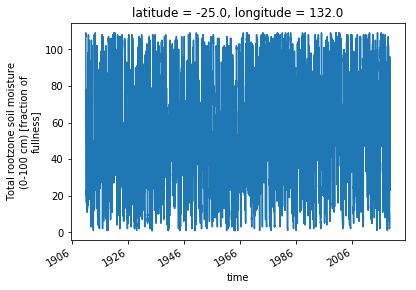

In [8]:
r[:,300,400].plot()

In [ ]:
climtas.io.to_netcdf_throttled(r, '~/scratch/test.nc')